In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi
import numpy as np
import os
import sys
from sklearn.metrics import accuracy_score, f1_score, precision_score
import geopandas
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data import *
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings("ignore")

### Load the necessary data

In [34]:
dist_path ='../data/shapefiles/tanzania_districts/Districts.shx'
feature_path = "../data/training_values.txt"
label_path = "../data/training_set_labels.csv"
y_pred_path = "../data/y_preds_test.csv"
districts = geopandas.read_file(dist_path)
features = pd.read_csv(feature_path)
label = pd.read_csv(label_path).rename(columns = {'status_group':'y_true'})
y_preds = pd.read_csv(y_pred_path).rename(columns = {'status_group':'y_pred'})

In [35]:
features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Create dataframe of true and predicted labels for each well

In [6]:
df_acc = pd.merge(features[['id', 'lga', 'population']], label, on = 'id')
df_acc = pd.merge(df_acc, y_preds, on = 'id')
df_acc.replace(to_replace = ['functional', 'functional needs repair', 'non functional'],
               value = [2,1,0], inplace = True)

### Group data by region and calculate score for each region

In [7]:
df_grouped = df_acc.sort_values(by = 'lga', axis = 0).groupby('lga').count().reset_index()[['lga','id']]
recall_scores = []
accuracy_scores = []
precision_scores = []
f1_scores = []
for district in df_grouped['lga']:
    dist_df = df_acc[df_acc['lga'] == district]
    accuracy_scores.append(round(accuracy_score(dist_df['y_true'], dist_df['y_pred']),2))
    recall_scores.append(round(well_recall(dist_df['y_true'], dist_df['y_pred']),2))
    precision_scores.append(round(precision_score(dist_df['y_true'], dist_df['y_pred'], 
                                                  average = None)[0],2))
    f1_scores.append(round(f1_score(dist_df['y_true'], dist_df['y_pred'],
                                    average = None)[0],2))
df_grouped['recall_score'] = recall_scores
df_grouped['accuracy_score'] = accuracy_scores
df_grouped['precision_score'] = precision_scores
df_grouped['f1_score'] = f1_scores

### Clean up district names so district names in geodata and scoring dataframes so names match and merging is successful

In [8]:
df_grouped['lga'] = df_grouped['lga'].str.replace(' Rural','')
districts.loc[districts['District_N'] == 'Kigoma  Urban', 'District_N'] = 'Kigoma Urban'
districts.loc[districts['District_N'] == 'Misungwi', 'District_N'] = 'Missungwi'
districts.loc[districts['District_N'] == 'Tanga Urban', 'District_N'] = 'Tanga'
districts.loc[districts['District_N'] == 'Missenyi', 'District_N'] = 'Misenyi'

### Merge scoring dataframe and geodata dataframe to prepare for cholopleth mapping

In [11]:
df_geo = pd.merge(df_grouped, districts, 
                  how = 'right', 
                  left_on = 'lga', 
                  right_on = 'District_N').drop(columns = ['District_C','District_N'])
df_geo = geopandas.GeoDataFrame(df_geo)

### Create dataframe of non-functional well locations for mapping markers

In [15]:
wells_nonfunc = pd.merge(features,label, on = 'id')
wells_nonfunc.loc[wells_nonfunc['longitude'] == 0, 'longitude'] = np.nan
wells_nonfunc = geopandas.GeoDataFrame(wells_nonfunc[['latitude','longitude','y_true']],
                               geometry = geopandas.points_from_xy(wells_nonfunc.longitude, 
                                                                   wells_nonfunc.latitude))
wells_nonfunc = wells_nonfunc.set_crs(epsg = 4210)
wells_nonfunc = wells_nonfunc[wells_nonfunc['y_true'] == 'non functional']

### In which regions are we most accurately predicting failed wells?  About how many wells are in those regions?

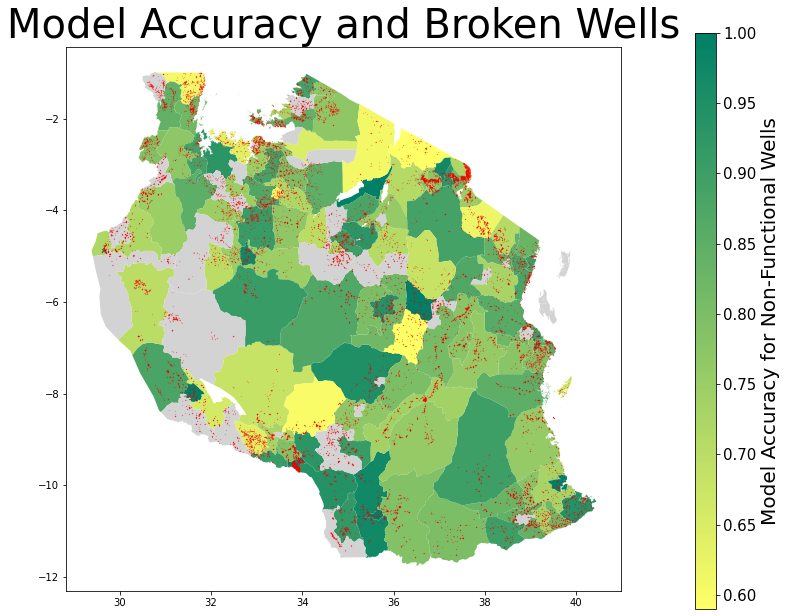

In [33]:
fig, ax = plt.subplots(figsize = (10,10))
cmap='summer_r'

df_geo.plot(ax = ax,
           column = 'accuracy_score',
           legend = False,
           cmap = cmap,
           missing_kwds = {'color':'lightgrey'} #Breaks the map if no NaNs
           )

ax.set_title('Model Accuracy and Broken Wells', fontsize = 40, y=.8)
vmin = df_geo['accuracy_score'].min()
vmax = df_geo['accuracy_score'].max()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=15) 
cbr.set_label('Model Accuracy for Non-Functional Wells', fontsize = 20)

wells_nonfunc.plot(ax = ax, color = 'red', markersize = .01)

plt.savefig('figures/accuracy_map', bbox_inches = 'tight')
plt.show()

## Check which regions we are most accurate in (90% or better).

In [32]:
best_accuracy = df_geo.sort_values(by = 'precision_score', ascending = False).drop(columns = 'geometry').reset_index()
best_accuracy = best_accuracy.rename({'id':'number_of_wells'}, axis = 1).fillna(0)
best_accuracy['number_of_wells'] = best_accuracy['number_of_wells'].astype(int)
cols = ['lga','precision_score','recall_score','number_of_wells']
best_accuracy = best_accuracy[cols]
acc_table = best_accuracy.head(30)
dfi.export(acc_table,'figures/best_accuracy_df.png')
acc_table

,lga,precision_score,recall_score,number_of_wells
0,Bahi,1.00,0.44,50
1,Chamwino,1.00,0.94,74
2,Arusha Urban,1.00,1.00,9
3,Kongwa,1.00,1.00,72
4,Mbinga,1.00,0.98,154
5,Tabora Urban,1.00,0.95,32
6,Temeke,1.00,0.82,41
7,Kigoma Urban,1.00,0.92,19
8,Bukombe,1.00,0.83,100
9,Karatu,1.00,1.00,64
